# Training a Taxi Driver
The Taxi Problem involves navigating to passengers in a grid world, picking them up and dropping them off at one of four locations.

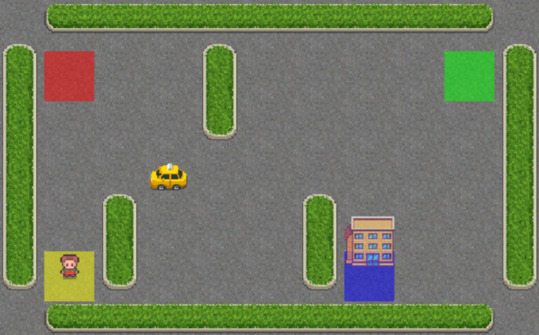

There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations.

The goal is move the taxi to the passenger’s location, pick up the passenger, move to the hotel, and drop off the passenger. Once the passenger is dropped off, the episode ends.

The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and for each step where another reward is not received.

# 1. Import libraries

In [1]:
# Environment
import gym

# Scientific modules
import numpy as np
import random

# System module
import joblib

- *gym* contains the Taxi environment
- *numpy* is used for agent's learning
- *random* is used for agent exploration
- *joblib* module is used here to save agent objects to files

# 2. Define Agent
Create the taxi driver agent to be trained. The agent is trained using Q-learing with an $\epsilon-$greedy policy. 
$$
\begin{align}
&\text{Q-learning update : } Q_{t+1}^{i+1}(s, a) \leftarrow Q_{t+1}^{i}(s, a) + \alpha \cdot \left[r + \gamma \max_{a'}  Q_t(s', a') - Q_{t+1}^{i}(s, a)\right] 
\end{align}
$$
The term $\gamma \max_{a'}  Q_t(s', a')$ is active for non-terminal transitions only.

In [2]:
class taxiDriver():
    def __init__(self):
        self.name = "taxiDriver"

    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            agent name: string,
            state size: integer,
            action size: intege,
            discount_factor: float,
            learning rate: float,
            epsilon: float,
            decay rate: float
        }
        """
        self.state_size = agent_config['state_size']
        self.action_size = agent_config['action_size']
    
        self.name = "taxiDriver_{}".format(agent_config['agent_name'])
        self.discount_rate = agent_config['gamma']
        self.learning_rate = agent_config['alpha']
        self.epsilon = agent_config['epsilon']
        
        self.qtable = np.zeros((self.state_size, self.action_size))

        self.last_state = None
        self.last_action = None

        self.episode_steps = 0

    def agent_step(self, state, actions):
        """
        Args:
            state (Numpy array): the state.
            actions (Discrete(6)): the action space
        Returns:
            the action.
        """
        if random.uniform(0,1) < self.epsilon:
            # explore
            action = actions.sample()
        else:
            # exploit
            action = np.argmax(self.qtable[state,:])
        self.last_state = state
        self.last_action = action
        self.episode_steps += 1      
        return action

    
    def agent_learn(self, reward, new_state, terminal):   
        """
        Args:
            reward (float): the reward the agent received for taking the
                last action.
            new_state (Numpy array): the new state after taking the last action.
            terminal (boolean): is new state a terminal state or not
        """     
        # Q-learning algorithm
        if not terminal:
            self.qtable[self.last_state, self.last_action] = self.qtable[self.last_state, self.last_action] \
                + self.learning_rate * (reward + self.discount_rate * np.max(self.qtable[new_state,:]) \
                                    - self.qtable[self.last_state, self.last_action])
        else:
            self.qtable[self.last_state, self.last_action] = self.qtable[self.last_state, self.last_action] \
                + self.learning_rate * (reward - self.qtable[self.last_state, self.last_action])    

# 3. Define Experiment
The experiment calls the *Taxi* environment from *gymnasium*. Each episode runs until termination or timeout, training the taxi driver agent. As training progresses, exploration parameter $\epsilon$ decays over the episodes.

In [3]:
def run_experiment(current_agent, environment_parameters, agent_parameters, experiment_parameters):
    
    # experiment hyperparameters
    num_episodes = experiment_parameters['num_episodes']
    max_steps = experiment_parameters['timeout']
    decay_rate = experiment_parameters['decay_rate']    
    
    # start environment
    env_info = environment_parameters
    env = gym.make(env_info['name'], render_mode = env_info['render_mode'])

    # initialize agent
    agent_parameters['state_size'] = env.observation_space.n
    agent_parameters['action_size'] = env.action_space.n
    current_agent.agent_init(agent_parameters)
    
    # training
    for episode in range(num_episodes):

        # reset the environment
        observation = env.reset()
        state = observation[0]
        terminal = False

        while not terminal and (current_agent.episode_steps < max_steps):

            # choose next agent action
            action = current_agent.agent_step(state, env.action_space)

            # take action and observe reward
            new_state, reward, terminated, truncated, info = env.step(action)

            # is the episode done?
            terminal = terminated or truncated
            
            # train agent
            current_agent.agent_learn(reward, new_state, terminal)
            
            # Update state
            state = new_state
            
        # Decrease epsilon & reset episode steps
        current_agent.epsilon = np.exp(-decay_rate*episode)
        current_agent.episode_steps = 0
    env.close()    
    print(f"Training completed over {num_episodes} episodes")
    

# 4. Run experiment
Define the experiment, environment, and agent parameters for the experiment. After learning is done, save the trained agent.

In [4]:
def main():
    # Run Experiment

    # Experiment parameters
    experiment_parameters = {
        "num_runs": 1,
        "num_episodes": 1000,
        # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after
        # some number of timesteps. Here we use the default of 500.
        "timeout": 99,
        "decay_rate": 0.005
    }
    

    # Environment parameters
    environment_parameters = {
        'name': 'Taxi-v3',
        'render_mode': 'rgb_array'}

    # Agent parameters
    agent_parameters = {
        'agent_name': "1",
        'gamma': 0.8,
        'alpha': 0.9,
        'epsilon': 0.1
    }
    current_agent = taxiDriver()

    # run experiment
    run_experiment(current_agent, environment_parameters, agent_parameters, experiment_parameters)
    
    # save trained agent
    joblib.dump(current_agent, "agent_Q_1run_1000episodes.pickle")
    
    

In [5]:
if __name__ == "__main__":
    main()

Training completed over 1000 episodes


# Get the environment to run with the trained agent!

In [6]:
# watch trained agent
print('Start')

# load and initialize Taxi environment
env = gym.make('Taxi-v3', render_mode = 'human')
observation = env.reset()
state = observation[0]
rewards = 0
max_steps = 100
terminal = False

# load trained agent
current_agent = joblib.load("agent_Q_1run_1000episodes.pickle") 
current_agent.epsilon = 0
current_agent.episode_steps = 0

while not terminal and (current_agent.episode_steps < max_steps):   
    action = current_agent.agent_step(state, env.action_space)
    new_state, reward, terminated, truncated, info = env.step(action)
    rewards += reward
    state = new_state
    terminal = terminated or truncated
    if terminated or truncated:
        break
print(f"score: {rewards}")
#env.close()


Start
score: 6
